In [ ]:
# Install pyspark

!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=628e51ef9e8ccd8e8ae9bf1b1a5e5478f5f2f53b71b617184c196c8b40fb9faa
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [ ]:
# Import libraries

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import tqdm
import psutil
import time
import math

from google.colab import drive

In [ ]:
# Create spark session
spark = SparkSession.builder.getOrCreate()

# Create spark context
sc = spark.sparkContext

# Check how much memory is allocated to spark runtime
mem_info = psutil.virtual_memory()
total_memory_gb = mem_info.total / (1024 * 1024 * 1024)
print("Total Memory Allocated to Spark Runtime:", int(total_memory_gb), "GB")

Total Memory Allocated to Spark Runtime: 12 GB


In [ ]:
# Mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data
folder = '/content/drive/MyDrive/Colab Notebooks/cse 547 - hw 4/svm data/'
name = 'features.txt'
path = folder + name

features = spark.read.csv(path, inferSchema = True)

name = 'target.txt'
path = folder + name
target = spark.read.csv(path, inferSchema = True)

In [ ]:
# Inspect data
print(target.count() == features.count())

print(features.show())
print(target.show())

True
+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|_c0|_c1|_c2|_c3|_c4|_c5|_c6|_c7|_c8|_c9|_c10|_c11|_c12|_c13|_c14|_c15|_c16|_c17|_c18|_c19|_c20|_c21|_c22|_c23|_c24|_c25|_c26|_c27|_c28|_c29|_c30|_c31|_c32|_c33|_c34|_c35|_c36|_c37|_c38|_c39|_c40|_c41|_c42|_c43|_c44|_c45|_c46|_c47|_c48|_c49|_c50|_c51|_c52|_c53|_c54|_c55|_c56|_c57|_c58|_c59|_c60|_c61|_c62|_c63|_c64|_c65|_c66|_c67|_c68|_c69|_c70|_c71|_c72|_c73|_c74|_c75|

In [ ]:
# Transform data
f_arr = np.array(features.collect())
t_arr = np.array(target.collect())

In [ ]:
# Inspect transformed data
print(f_arr.shape)
print(t_arr.shape)
print(f_arr[ :3, :10])
print(t_arr[ :3])

(6414, 122)
(6414, 1)
[[0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0]]
[[-1]
 [-1]
 [ 1]]
(122,)


In [ ]:
##
# Function to calculate the loss function
#

# A helper function to calculate the summand
def L(w, b, x, y):
    l = 1 - y * (np.dot(w, x) + b)
    l = l[0]

    if l > 0:
        return l
    else:
        return 0


def total_loss(w, b, features, labels):
    n = features.shape[0]

    f = 0
    f += 0.5 * (np.linalg.norm(w, 2) ** 2)

    for i in range(n):
        f += C * L(w, b, features[i], labels[i])

    return f

In [ ]:
##
# Function to select a batch of size Beta
#

# Helper function to calculate the range of indices
def batch_idx(Beta, k, n):
    a = Beta * k + 1
    b = np.min([Beta * (k + 1), n])

    return np.arange(a, b + 1) - 1


def Batch(features, labels, batch_size, k, n):
    idx = batch_idx(Beta = batch_size, k = k, n = n)

    return features[idx], labels[idx]


# Test helper function
Beta = 3
k = 2
idx = batch_idx(Beta = Beta, k = k, n = 6414)
print(idx)
print(Beta == t_arr[idx].shape[0])

# Test behavior of Batch function
B = Batch(f_arr, t_arr, batch_size = Beta, k = k, n = 6414)

# Test loss function with batch from Batch function
total_loss(w = np.zeros(122), b = 0, features = B[0], labels = B[1])

[6 7 8]
True


300.0

In [ ]:
##
# Function to set global parameters
#

def init_params(features, labels,
                lr, batch_size, tol, C):

    n = features.shape[0] # Number of samples
    d = features.shape[1] # Number of features

    eta = lr # Learning rate
    Beta = batch_size # Batch size
    eps = tol # Convergence tolerance
    k = 0 # For selecting batches

    w0 = np.zeros(d) # Initially 0 vector
    b0 = 0 # Initially 0
    C = C # A hyper-parameter

    t = 0 # Iteration counter

    return n, d, eta, Beta, eps, k, t, w0, b0, C


# Test init_params function
n, d, eta, Beta, eps, k, t, w0, b0, C = init_params(f_arr, t_arr,
                                                    lr = 3e-7, batch_size = 1,
                                                    tol = 0.25, C = 100)
# Check loss function
total_loss(w0, b0, f_arr, t_arr) == 641400

True

In [ ]:
##
# Function to update k
#

def k_up(k, n, Beta):
    return (k + 1) % (math.ceil(n / Beta))

In [ ]:
##
# List to store values of loss function across iterations
#

def init_Losses():
    return [total_loss(w0, b0, f_arr, t_arr)]

In [ ]:
##
# Functions to calculate partial derivatives wrt b and w


# Helper function to indicate whether x is on the right side
# of the support vector. 0 if x is further from the max-margin
# hyper-plane than the support vector, 1 otherwise.
def is_WrongSide(w, b, x, y):
    h = y * (np.dot(w, x) + b)

    if h >= 1:
        return 0
    else:
        return 1

# Returns partial derivatives wrt b and w (wrt each w_j in an array)
def partial_derivs(w, b, C, x_batch, y_batch):

    d = x_batch.shape[1]

    b_sum = 0
    w_sums = np.zeros_like(w)

    for x, y in zip(x_batch, y_batch):

        is_CausingLoss = is_WrongSide(w, b, x, y)

        y = y[0] # y is now a scalar
        b_sum += C * is_CausingLoss * -y

        for j in range(d):
            w_sums[j] += w[j] + C * is_CausingLoss * -y * x[j]


    return b_sum, w_sums


# Test behavior
w = np.zeros(d)
b = 0
C = 100
Beta = 5

x_batch, y_batch = Batch(f_arr, t_arr, batch_size = Beta, k = 0, n = 6414)

b_deriv, w_derivs = partial_derivs(w, b, C, x_batch, y_batch)

print(b_deriv)
print(w_derivs)

300
[ 100.    0.  200.    0.    0.  100.  100.    0.    0.    0.  100.    0.
    0.  100.    0.  100.  200. -100.  100. -100.    0.  200.    0.    0.
    0.    0.  100.    0.    0.    0.    0.    0.    0.    0.  100.  200.
 -100.    0.  100.    0.  100.  200.    0.    0.    0.    0.    0.    0.
    0.    0. -100.    0.  100.    0.  100.  100.  100.    0.    0.    0.
    0.  100.    0.  200.    0.    0.  300.    0.  100.    0. -100.    0.
  300.  200.  100.  300.    0.    0.  100.  200.  100. -100.  200.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.  100.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.]


In [ ]:
##
# Gradient descent algorithm
#

f_arr_copy = f_arr
t_arr_copy = t_arr

def gradient_descent(variant):

    # Initialize parameters
    if variant == 'BGD':
        n, d, eta, Beta, eps, k, t, w, b, C = init_params(f_arr, t_arr,
                                                          lr = 3 * (10 ** (-7)),
                                                          batch_size = 6414,
                                                          tol = 0.25,
                                                          C = 100)

    if variant == 'SGD':
        n, d, eta, Beta, eps, k, t, w, b, C = init_params(f_arr, t_arr,
                                                          lr = 0.0001,
                                                          batch_size = 1,
                                                          tol = 0.001,
                                                          C = 100)

    if variant == 'MBGD':
        n, d, eta, Beta, eps, k, t, w, b, C = init_params(f_arr, t_arr,
                                                          lr = 10**(-5),
                                                          batch_size = 20,
                                                          tol = 0.01,
                                                          C = 100)


    # Shuffle the training data (only for SGD/MBGD)
    if variant == 'SGD' or variant == 'MBGD':

        indices = np.arange(f_arr.shape[0])
        np.random.shuffle(indices)

        f_arr_copy = f_arr[indices]
        t_arr_copy = t_arr[indices]

    else:

        f_arr_copy = f_arr
        t_arr_copy = t_arr



    # Initialize Losses list with 0th loss
    Losses = init_Losses()
    chg_loss = 0
    converged = False

    # Start the clock
    start_time = time.time()
    #
    #
    #


    # for s in range(10):
    while not converged:

        ##
        # Select batch of size Beta
        x_batch, y_batch = Batch(f_arr_copy, t_arr_copy,
                                 batch_size = Beta, k = k, n = n)


        ##
        # Calculate the partial derivatives wrt b and wrt each w_j
        b_deriv, w_derivs = partial_derivs(w, b, C, x_batch, y_batch)

        # Update each entry of w following the path of steepest descent
        # Size of step along path is controlled by learning rate (eta)
        for j in range(d):
            w[j] = w[j] - eta * w_derivs[j]

        # Update b likewise
        b = b - eta * b_deriv


        ##
        # Update k
        k = k_up(k, n, Beta)

        # Increment iteration counter
        t += 1

        # Calculate loss at the end of this iteration
        Loss = total_loss(w = w, b = b, features = f_arr_copy,
                                        labels = t_arr_copy)

        # Append to the list of Losses
        Losses.append(Loss)


        # check convergence criteria
        pct_chg_loss = 100 * np.abs(Losses[t - 1] - Losses[t]) / Losses[t - 1]

        chg_loss = 0.5 * chg_loss + 0.5 * pct_chg_loss

        if variant == 'BGD':
            converged = (pct_chg_loss < eps)
        else:
            converged = (chg_loss < eps)


    print(pct_chg_loss)
    print(chg_loss)

    #
    #
    # Report the total time (wall clock time) the algorithm takes to converge
    end_time = time.time()
    elapsed_time = np.round(end_time - start_time, 5)
    print(f'Time taken: {elapsed_time} seconds')
    print(f'Number of iterations = {t}')

    return elapsed_time, t, Losses

In [ ]:
elapsed_time, t, Losses = gradient_descent('SGD')
SGD_results = [elapsed_time, t, Losses]

0.00044936771396882834
0.0009649673159268436
Time taken: 132.15786 seconds
Number of iterations = 2682


In [ ]:
elapsed_time, t, Losses = gradient_descent('BGD')
BGD_results = [elapsed_time, t, Losses]

0.24062085180959072
0.24872267246509988
Time taken: 54.72451 seconds
Number of iterations = 58


In [ ]:
elapsed_time, t, Losses = gradient_descent('MBGD')
MBGD_results = [elapsed_time, t, Losses]

0.0028189470065545074
0.006555544412755
Time taken: 70.46964 seconds
Number of iterations = 1224


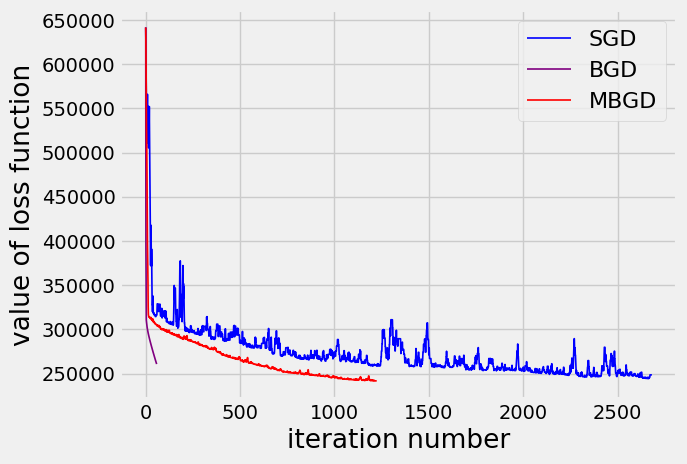

In [ ]:
##
# Plot the loss function vs. iteration number starting from t = 0
#

# For SGD
elapsed_time_sgd, t_sgd, Losses_sgd = SGD_results
iter_sgd = np.arange(t_sgd + 1)

# For BGD
elapsed_time_bgd, t_bgd, Losses_bgd = BGD_results
iter_bgd = np.arange(t_bgd + 1)

# For MBGD
elapsed_time_mbgd, t_mbgd, Losses_mbgd = MBGD_results
iter_mbgd = np.arange(t_mbgd + 1)

# Create a single plot
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()

# Plot for SGD
ax.plot(iter_sgd, Losses_sgd, label='SGD', color='blue', linewidth = 1.2)

# Plot for BGD
ax.plot(iter_bgd, Losses_bgd, label='BGD', color='purple', linewidth = 1.2)

# Plot for MBGD
ax.plot(iter_mbgd, Losses_mbgd, label='MBGD', color='red', linewidth = 1.2)

# Set labels
ax.set_xlabel('iteration number', fontsize = 19)
ax.set_ylabel('value of loss function', fontsize = 19)

# Add legend
ax.legend(fontsize = 16)

# Show plot
plt.show()